In [1]:
import glob
import os
import re
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.ndimage import binary_dilation, label
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, \
    classification_report, confusion_matrix
import seaborn as sns
import joblib

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

image_dir = "E:\\PycharmProjects\\nina\\walrus\\data\\train\\clipped_images"
shapefile_dir = "E:\\PycharmProjects\\nina\\walrus\\data\\train\\clipped_train"
unlabeled_image_dir = "E:\\PycharmProjects\\nina\\walrus\\data\\train\\clipped_unlabeled"
new_walrus_dir = "E:\\PycharmProjects\\nina\\walrus\\data\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

def pair_files(image_paths, shapefile_paths):
    pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if matching_shapefiles:
            pairs[image_path] = matching_shapefiles[0]

    return pairs

training_pairs = pair_files(image_paths, shapefile_paths)
validation_pairs = pair_files(unlabeled_image_paths, new_walrus_paths)

def extract_features_labels(image_path, shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []

    gdf = gpd.read_file(shapefile)
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        for pixel in feature_pixels.T:
            features.append(pixel)
            labels.append(row['label'])

    return np.array(features), np.array(labels)

def get_dataset(file_pairs):
    features = []
    labels = []

    for image_path, shapefile in file_pairs.items():
        img_features, img_labels = extract_features_labels(image_path, shapefile)
        features.append(img_features)
        labels.append(img_labels)

    features = np.vstack(features)
    labels = np.hstack(labels)

    return features, labels

# Get the dataset
features, labels = get_dataset(training_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Combine classes
combined_labels = np.where(np.isin(labels, ['rock', 'ice', 'freshwater']), 'land',
                           np.where(np.isin(labels, ['walrus_pure', 'walrus_mixed']), 'walrus', labels))
combined_le = LabelEncoder()
combined_encoded_labels = combined_le.fit_transform(combined_labels)

In [3]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, combined_encoded_labels, test_size=0.2, stratify=combined_encoded_labels, random_state=42)

In [5]:
# Train the binary ocean/not-ocean model
binary_model = RandomForestClassifier(n_estimators=100, random_state=42)
binary_y_train = (y_train == combined_le.transform(['ocean'])[0]).astype(int)
binary_model.fit(X_train, binary_y_train)

joblib.dump(binary_model, 'binary_ocean_not_ocean_model11.joblib')

['binary_ocean_not_ocean_model11.joblib']

In [6]:
# Train the walrus model on all bands
walrus_model = XGBClassifier(random_state=42)
land_mask = y_train != combined_le.transform(['ocean'])[0]
walrus_y_train = (y_train[land_mask] == combined_le.transform(['walrus'])[0]).astype(int)
walrus_model.fit(X_train[land_mask], walrus_y_train)

joblib.dump(walrus_model, 'walrus_vs_land_model11.joblib')

['walrus_vs_land_model11.joblib']

In [7]:
binary_model = joblib.load('binary_ocean_not_ocean_model11.joblib')
walrus_model = joblib.load('walrus_vs_land_model11.joblib')

In [12]:
def remove_speckles(prediction, min_size=100, target_classes=None):
    labeled_array, num_features = label(prediction)
    sizes = np.bincount(labeled_array.ravel())
    mask_sizes = sizes > min_size
    mask_sizes[0] = 0  # Ensure background is not considered

    prediction_cleaned = np.copy(prediction)
    for i in range(1, num_features + 1):
        if sizes[i] <= min_size:
            region_mask = labeled_array == i
            if target_classes is None or np.any(np.isin(prediction[region_mask], target_classes)):
                prediction_cleaned[region_mask] = 0  # Set small regions to background

    return prediction_cleaned

def post_process_prediction(prediction, original_shape=None, passes=3):
    print("Inside post_process_prediction function.")
    
    is_1d = prediction.ndim == 1
    print(f"Initial prediction shape: {prediction.shape}")
    print(f"Initial is_1d: {is_1d}")

    if original_shape is not None and is_1d:
        prediction = prediction.reshape(original_shape)
        is_1d = False
        print(f"Reshaped prediction to: {prediction.shape}")

    ocean_value = combined_le.transform(['ocean'])[0]
    walrus_value = combined_le.transform(['walrus'])[0]
    land_value = combined_le.transform(['land'])[0]

    for pass_num in range(passes):
        print(f"Pass {pass_num + 1}/{passes}")
        ocean_mask = prediction == ocean_value
        print(f"Ocean mask sum: {ocean_mask.sum()}")

        ocean_mask_2d = ocean_mask
        structure = np.ones((30, 30), dtype=bool)  # 2D structure for 2D input

        print(f"Ocean mask 2D shape: {ocean_mask_2d.shape}")
        print(f"Structure shape: {structure.shape}")

        try:
            ocean_buffer = binary_dilation(ocean_mask_2d, structure=structure)
        except RuntimeError as e:
            print(f"Error during binary_dilation: {e}")
            return prediction

        print(f"Ocean buffer created. Shape: {ocean_buffer.shape}")

        walrus_mask = prediction == walrus_value
        walrus_mask[~ocean_buffer] = False
        prediction[walrus_mask] = walrus_value

        print(f"Walrus mask updated. Walrus count: {(prediction == walrus_value).sum()}")

        # Remove speckles
        prediction = remove_speckles(prediction, min_size=100, target_classes=[ocean_value, land_value])
        print(f"Speckles removed. Unique values: {np.unique(prediction)}")

        # Ensure only one large ocean region
        ocean_mask = prediction == ocean_value  # Recalculate the ocean mask after removing speckles
        labeled_ocean, num_ocean_features = label(ocean_mask)
        ocean_sizes = np.bincount(labeled_ocean.ravel())
        largest_ocean_label = ocean_sizes[1:].argmax() + 1  # largest connected component (ignoring background)

        for ocean_label in range(1, num_ocean_features + 1):
            if ocean_label != largest_ocean_label:
                prediction[labeled_ocean == ocean_label] = land_value

        print(f"Removed smaller ocean regions. Ocean mask sum after removal: {(prediction == ocean_value).sum()}")

    if is_1d:
        prediction = prediction.ravel()

    print(f"Final prediction shape: {prediction.shape}")
    return prediction




def predict_image(image_path, binary_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        height, width = image.shape[1], image.shape[2]

        image_reshaped = image.reshape(8, -1).T

        ocean_predictions = binary_model.predict(image_reshaped)

        land_mask = ocean_predictions == 0
        walrus_probabilities = walrus_model.predict_proba(image_reshaped[land_mask])[:, 1]

        walrus_threshold = 0.1
        walrus_predictions = (walrus_probabilities > walrus_threshold).astype(int)

        combined_predictions = np.zeros_like(ocean_predictions)
        combined_predictions[~land_mask] = combined_le.transform(['ocean'])[0]
        combined_predictions[land_mask] = np.where(walrus_predictions == 1,
                                                   combined_le.transform(['walrus'])[0],
                                                   combined_le.transform(['land'])[0])

        # combined_predictions = post_process_prediction(combined_predictions, (height, width))

        return combined_predictions, (height, width)

In [13]:
def predict_and_post_process(image_path, binary_model, walrus_model):
    combined_predictions, original_shape = predict_image(image_path, binary_model, walrus_model)
    post_processed_predictions = post_process_prediction(combined_predictions, original_shape)
    return post_processed_predictions, original_shape

Inside post_process_prediction function.
Initial prediction shape: (242707,)
Initial is_1d: True
Reshaped prediction to: (242707,)
Pass 1/3
Ocean mask sum: 155718
Ocean mask 2D shape: (242707,)
Structure shape: (30, 30)
Error during binary_dilation: structure and input must have same dimensionality
Model Evaluation Metrics (Post-processed):
Accuracy: 0.9967862484394764
Precision: 0.9960431907516901
Recall: 0.9967862484394764
F1 Score: 0.9964133768973241
Cohen's Kappa: 0.9930137662210685

Classification Report (Post-processed):


C:\Users\Owen\miniforge3\envs\walrus_nina\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Owen\miniforge3\envs\walrus_nina\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        land       0.99      1.00      1.00     86668
       ocean       1.00      1.00      1.00    155857
      walrus       0.00      0.00      0.00       182

    accuracy                           1.00    242707
   macro avg       0.66      0.67      0.66    242707
weighted avg       1.00      1.00      1.00    242707



C:\Users\Owen\miniforge3\envs\walrus_nina\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Owen\miniforge3\envs\walrus_nina\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


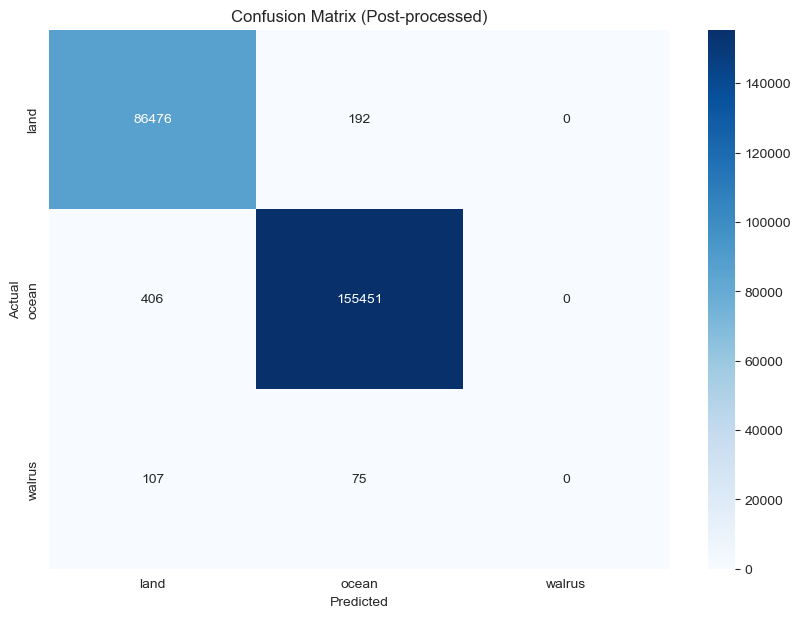

In [10]:
# Evaluate the model on the test set using post-processed predictions
def evaluate_model(X_test, y_test, binary_model, walrus_model):
    y_pred = binary_model.predict(X_test)
    land_mask = y_pred == 0
    y_pred[land_mask] = walrus_model.predict(X_test[land_mask])

    # Post-process the predictions
    y_pred_post = post_process_prediction(y_pred, original_shape=(len(y_pred),))

    # Calculate Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred_post)
    precision = precision_score(y_test, y_pred_post, average='weighted')
    recall = recall_score(y_test, y_pred_post, average='weighted')
    f1 = f1_score(y_test, y_pred_post, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred_post)

    # Print Metrics
    print("Model Evaluation Metrics (Post-processed):")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Cohen's Kappa: {kappa}")

    print("\nClassification Report (Post-processed):")
    print(classification_report(y_test, y_pred_post, target_names=combined_le.classes_))

    # Compute and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_post)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=combined_le.classes_,
                yticklabels=combined_le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Post-processed)')
    plt.show()

evaluate_model(X_test, y_test, binary_model, walrus_model)


Inside post_process_prediction function.
Initial prediction shape: (258990,)
Initial is_1d: True
Reshaped prediction to: (445, 582)
Pass 1/3
Ocean mask sum: 117818
Ocean mask 2D shape: (445, 582)
Structure shape: (30, 30)
Ocean buffer created. Shape: (445, 582)
Walrus mask updated. Walrus count: 4037
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 117700
Pass 2/3
Ocean mask sum: 117700
Ocean mask 2D shape: (445, 582)
Structure shape: (30, 30)
Ocean buffer created. Shape: (445, 582)
Walrus mask updated. Walrus count: 4036
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 117700
Pass 3/3
Ocean mask sum: 117700
Ocean mask 2D shape: (445, 582)
Structure shape: (30, 30)
Ocean buffer created. Shape: (445, 582)
Walrus mask updated. Walrus count: 4036
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 117700
Final prediction shape: (445, 5

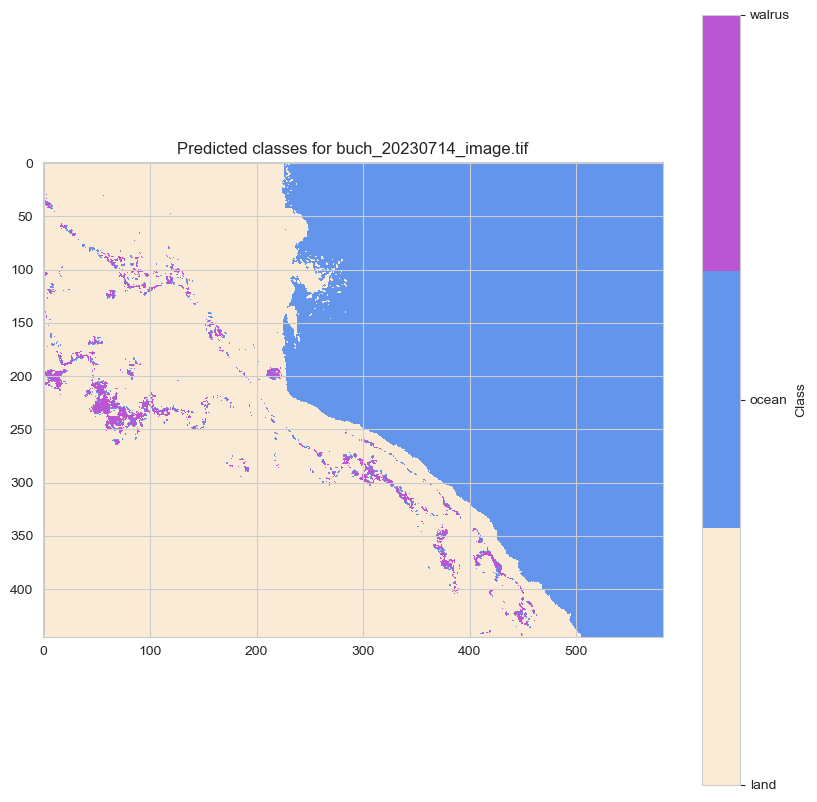

Inside post_process_prediction function.
Initial prediction shape: (404768,)
Initial is_1d: True
Reshaped prediction to: (556, 728)
Pass 1/3
Ocean mask sum: 219264
Ocean mask 2D shape: (556, 728)
Structure shape: (30, 30)
Ocean buffer created. Shape: (556, 728)
Walrus mask updated. Walrus count: 832
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 219076
Pass 2/3
Ocean mask sum: 219076
Ocean mask 2D shape: (556, 728)
Structure shape: (30, 30)
Ocean buffer created. Shape: (556, 728)
Walrus mask updated. Walrus count: 830
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 219076
Pass 3/3
Ocean mask sum: 219076
Ocean mask 2D shape: (556, 728)
Structure shape: (30, 30)
Ocean buffer created. Shape: (556, 728)
Walrus mask updated. Walrus count: 830
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 219076
Final prediction shape: (556, 728)

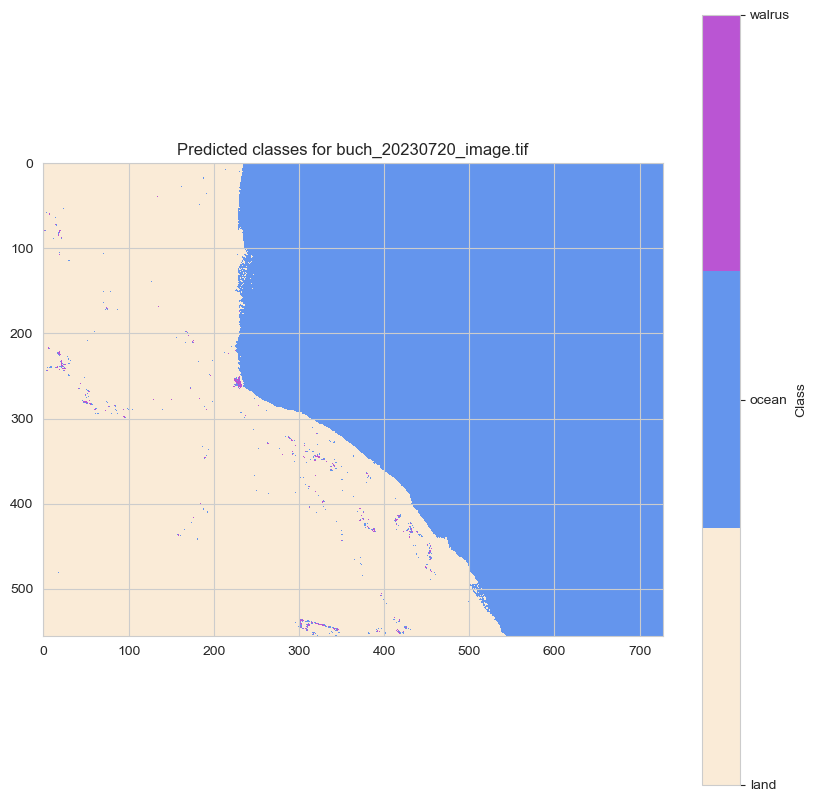

Inside post_process_prediction function.
Initial prediction shape: (311832,)
Initial is_1d: True
Reshaped prediction to: (488, 639)
Pass 1/3
Ocean mask sum: 164149
Ocean mask 2D shape: (488, 639)
Structure shape: (30, 30)
Ocean buffer created. Shape: (488, 639)
Walrus mask updated. Walrus count: 437
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 163994
Pass 2/3
Ocean mask sum: 163994
Ocean mask 2D shape: (488, 639)
Structure shape: (30, 30)
Ocean buffer created. Shape: (488, 639)
Walrus mask updated. Walrus count: 437
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 163994
Pass 3/3
Ocean mask sum: 163994
Ocean mask 2D shape: (488, 639)
Structure shape: (30, 30)
Ocean buffer created. Shape: (488, 639)
Walrus mask updated. Walrus count: 437
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 163994
Final prediction shape: (488, 639)

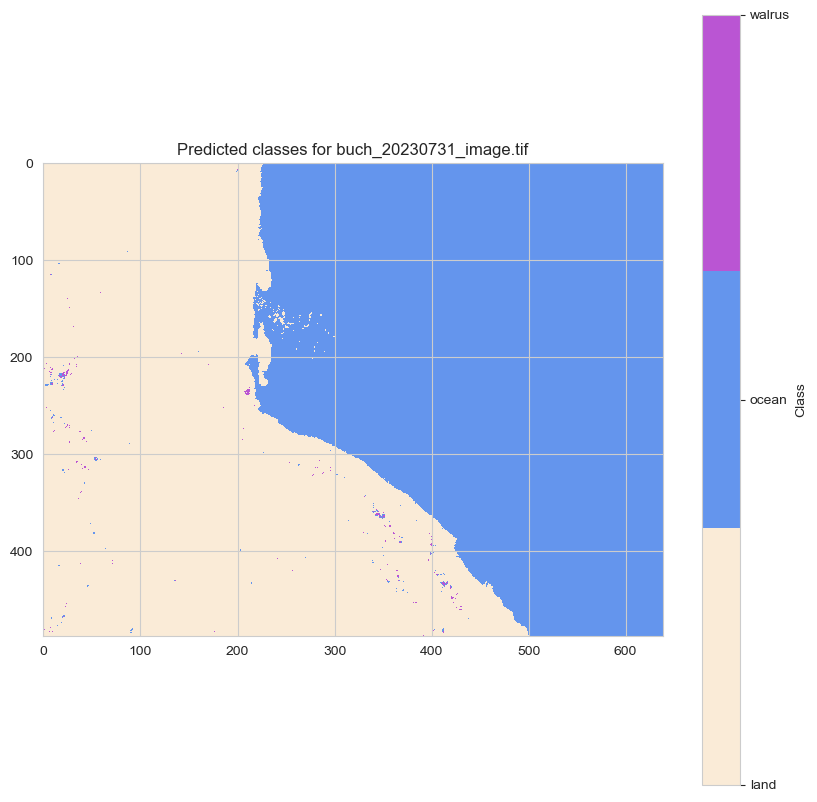

Inside post_process_prediction function.
Initial prediction shape: (165430,)
Initial is_1d: True
Reshaped prediction to: (355, 466)
Pass 1/3
Ocean mask sum: 80952
Ocean mask 2D shape: (355, 466)
Structure shape: (30, 30)
Ocean buffer created. Shape: (355, 466)
Walrus mask updated. Walrus count: 0
Speckles removed. Unique values: [0 1]
Removed smaller ocean regions. Ocean mask sum after removal: 80633
Pass 2/3
Ocean mask sum: 80633
Ocean mask 2D shape: (355, 466)
Structure shape: (30, 30)
Ocean buffer created. Shape: (355, 466)
Walrus mask updated. Walrus count: 0
Speckles removed. Unique values: [0 1]
Removed smaller ocean regions. Ocean mask sum after removal: 80633
Pass 3/3
Ocean mask sum: 80633
Ocean mask 2D shape: (355, 466)
Structure shape: (30, 30)
Ocean buffer created. Shape: (355, 466)
Walrus mask updated. Walrus count: 0
Speckles removed. Unique values: [0 1]
Removed smaller ocean regions. Ocean mask sum after removal: 80633
Final prediction shape: (355, 466)


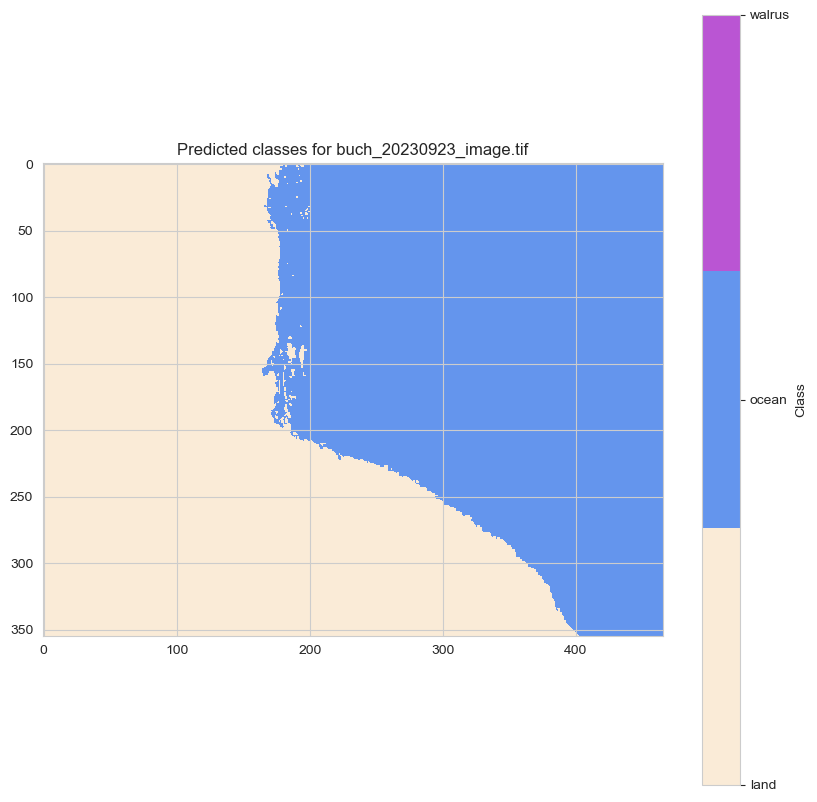

Inside post_process_prediction function.
Initial prediction shape: (131570,)
Initial is_1d: True
Reshaped prediction to: (295, 446)
Pass 1/3
Ocean mask sum: 111271
Ocean mask 2D shape: (295, 446)
Structure shape: (30, 30)
Ocean buffer created. Shape: (295, 446)
Walrus mask updated. Walrus count: 107
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 111260
Pass 2/3
Ocean mask sum: 111260
Ocean mask 2D shape: (295, 446)
Structure shape: (30, 30)
Ocean buffer created. Shape: (295, 446)
Walrus mask updated. Walrus count: 107
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 111260
Pass 3/3
Ocean mask sum: 111260
Ocean mask 2D shape: (295, 446)
Structure shape: (30, 30)
Ocean buffer created. Shape: (295, 446)
Walrus mask updated. Walrus count: 107
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 111260
Final prediction shape: (295, 446)

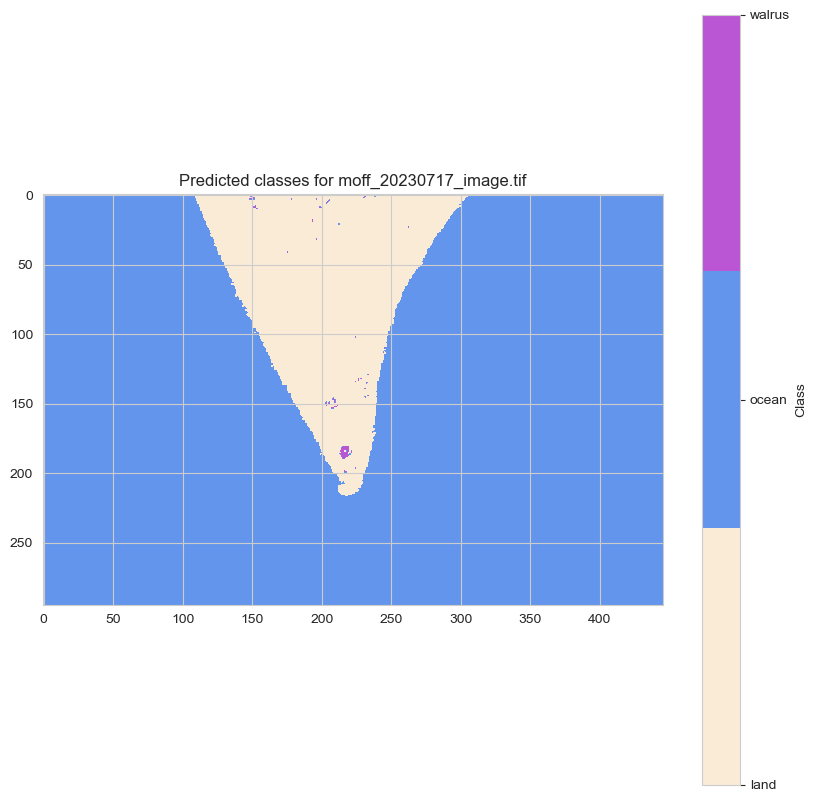

Inside post_process_prediction function.
Initial prediction shape: (159408,)
Initial is_1d: True
Reshaped prediction to: (324, 492)
Pass 1/3
Ocean mask sum: 61946
Ocean mask 2D shape: (324, 492)
Structure shape: (30, 30)
Ocean buffer created. Shape: (324, 492)
Walrus mask updated. Walrus count: 267
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 61746
Pass 2/3
Ocean mask sum: 61746
Ocean mask 2D shape: (324, 492)
Structure shape: (30, 30)
Ocean buffer created. Shape: (324, 492)
Walrus mask updated. Walrus count: 265
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 61746
Pass 3/3
Ocean mask sum: 61746
Ocean mask 2D shape: (324, 492)
Structure shape: (30, 30)
Ocean buffer created. Shape: (324, 492)
Walrus mask updated. Walrus count: 265
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 61746
Final prediction shape: (324, 492)


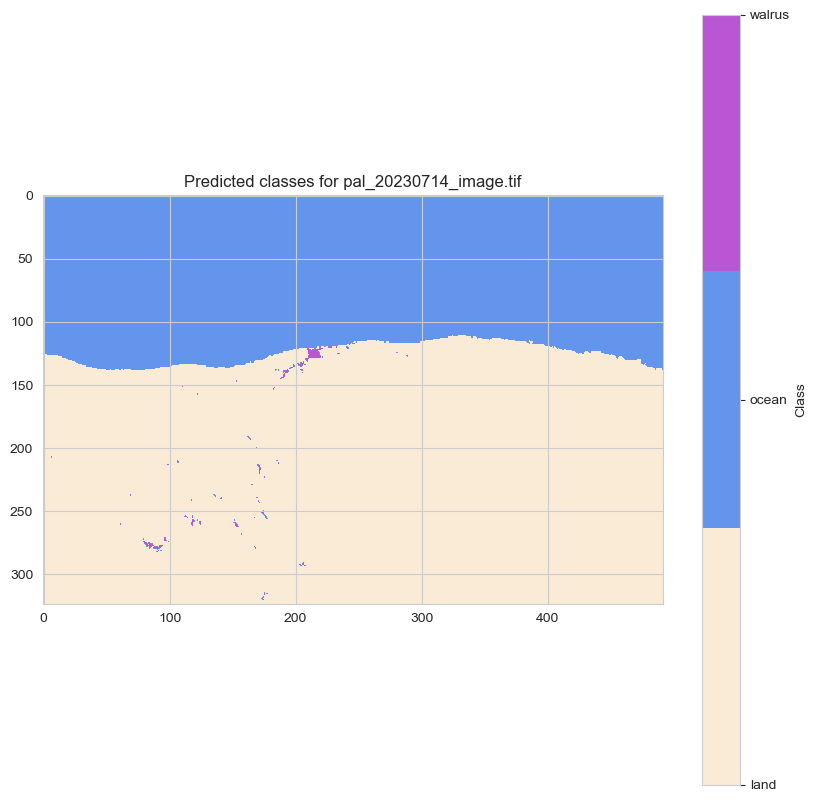

Inside post_process_prediction function.
Initial prediction shape: (74556,)
Initial is_1d: True
Reshaped prediction to: (218, 342)
Pass 1/3
Ocean mask sum: 26104
Ocean mask 2D shape: (218, 342)
Structure shape: (30, 30)
Ocean buffer created. Shape: (218, 342)
Walrus mask updated. Walrus count: 1230
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 26054
Pass 2/3
Ocean mask sum: 26054
Ocean mask 2D shape: (218, 342)
Structure shape: (30, 30)
Ocean buffer created. Shape: (218, 342)
Walrus mask updated. Walrus count: 1228
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 26054
Pass 3/3
Ocean mask sum: 26054
Ocean mask 2D shape: (218, 342)
Structure shape: (30, 30)
Ocean buffer created. Shape: (218, 342)
Walrus mask updated. Walrus count: 1228
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 26054
Final prediction shape: (218, 342)


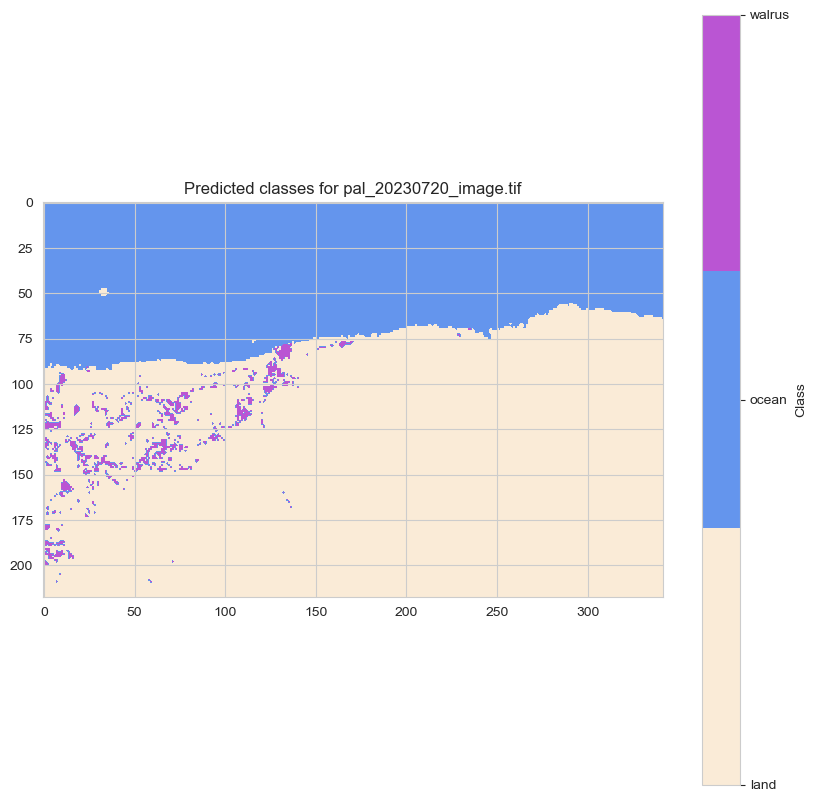

Inside post_process_prediction function.
Initial prediction shape: (192240,)
Initial is_1d: True
Reshaped prediction to: (356, 540)
Pass 1/3
Ocean mask sum: 78369
Ocean mask 2D shape: (356, 540)
Structure shape: (30, 30)
Ocean buffer created. Shape: (356, 540)
Walrus mask updated. Walrus count: 531
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 78136
Pass 2/3
Ocean mask sum: 78136
Ocean mask 2D shape: (356, 540)
Structure shape: (30, 30)
Ocean buffer created. Shape: (356, 540)
Walrus mask updated. Walrus count: 524
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 78136
Pass 3/3
Ocean mask sum: 78136
Ocean mask 2D shape: (356, 540)
Structure shape: (30, 30)
Ocean buffer created. Shape: (356, 540)
Walrus mask updated. Walrus count: 524
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 78136
Final prediction shape: (356, 540)


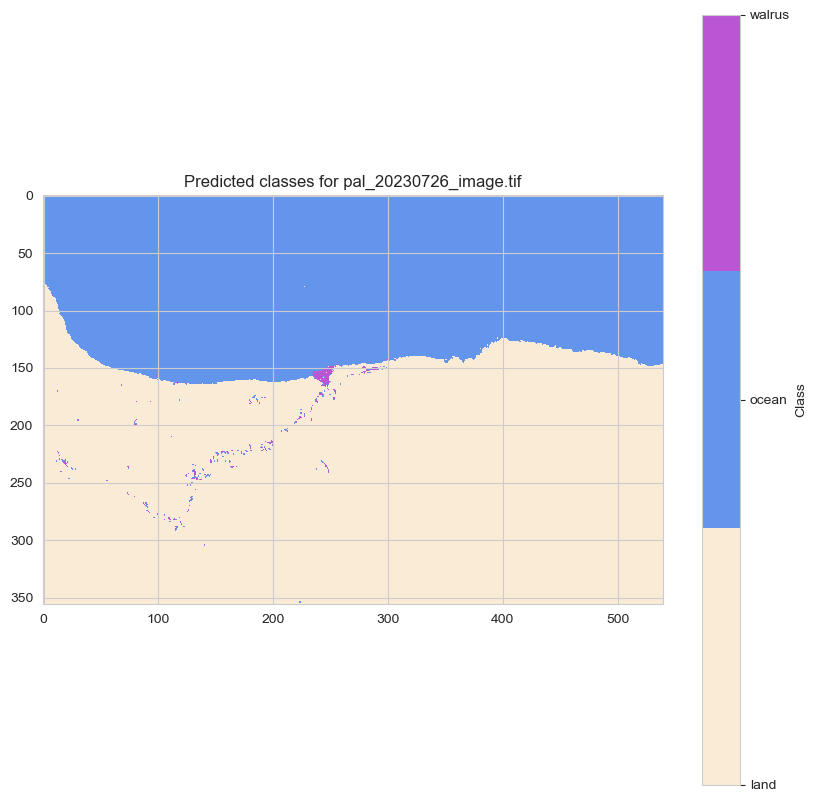

Inside post_process_prediction function.
Initial prediction shape: (97155,)
Initial is_1d: True
Reshaped prediction to: (255, 381)
Pass 1/3
Ocean mask sum: 71340
Ocean mask 2D shape: (255, 381)
Structure shape: (30, 30)
Ocean buffer created. Shape: (255, 381)
Walrus mask updated. Walrus count: 214
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 68445
Pass 2/3
Ocean mask sum: 68445
Ocean mask 2D shape: (255, 381)
Structure shape: (30, 30)
Ocean buffer created. Shape: (255, 381)
Walrus mask updated. Walrus count: 204
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 68445
Pass 3/3
Ocean mask sum: 68445
Ocean mask 2D shape: (255, 381)
Structure shape: (30, 30)
Ocean buffer created. Shape: (255, 381)
Walrus mask updated. Walrus count: 204
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 68445
Final prediction shape: (255, 381)


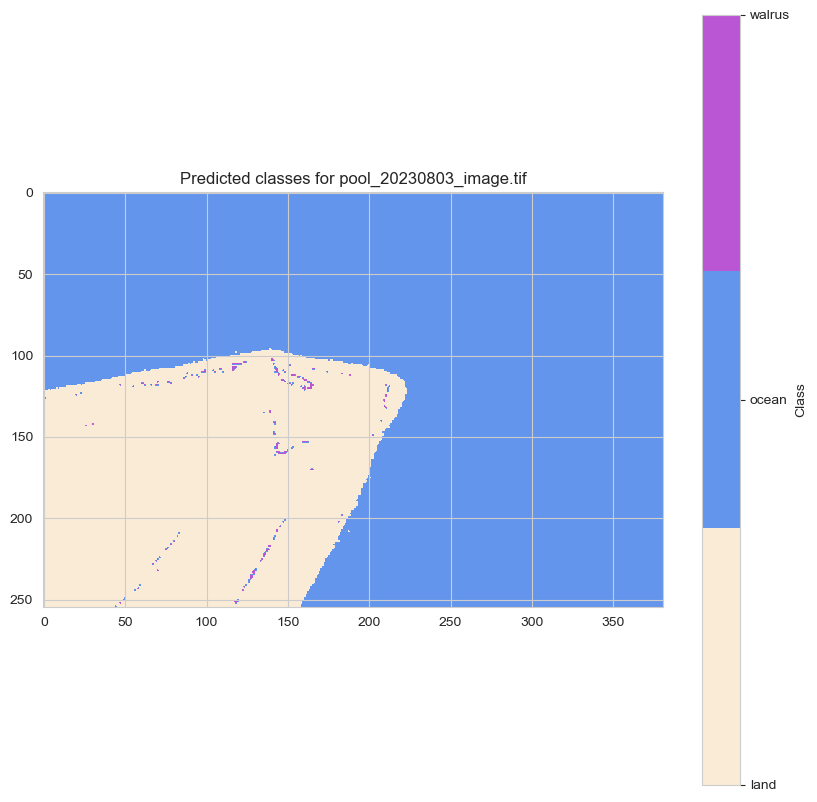

Inside post_process_prediction function.
Initial prediction shape: (243080,)
Initial is_1d: True
Reshaped prediction to: (412, 590)
Pass 1/3
Ocean mask sum: 235233
Ocean mask 2D shape: (412, 590)
Structure shape: (30, 30)
Ocean buffer created. Shape: (412, 590)
Walrus mask updated. Walrus count: 136
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 235226
Pass 2/3
Ocean mask sum: 235226
Ocean mask 2D shape: (412, 590)
Structure shape: (30, 30)
Ocean buffer created. Shape: (412, 590)
Walrus mask updated. Walrus count: 136
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 235226
Pass 3/3
Ocean mask sum: 235226
Ocean mask 2D shape: (412, 590)
Structure shape: (30, 30)
Ocean buffer created. Shape: (412, 590)
Walrus mask updated. Walrus count: 136
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 235226
Final prediction shape: (412, 590)

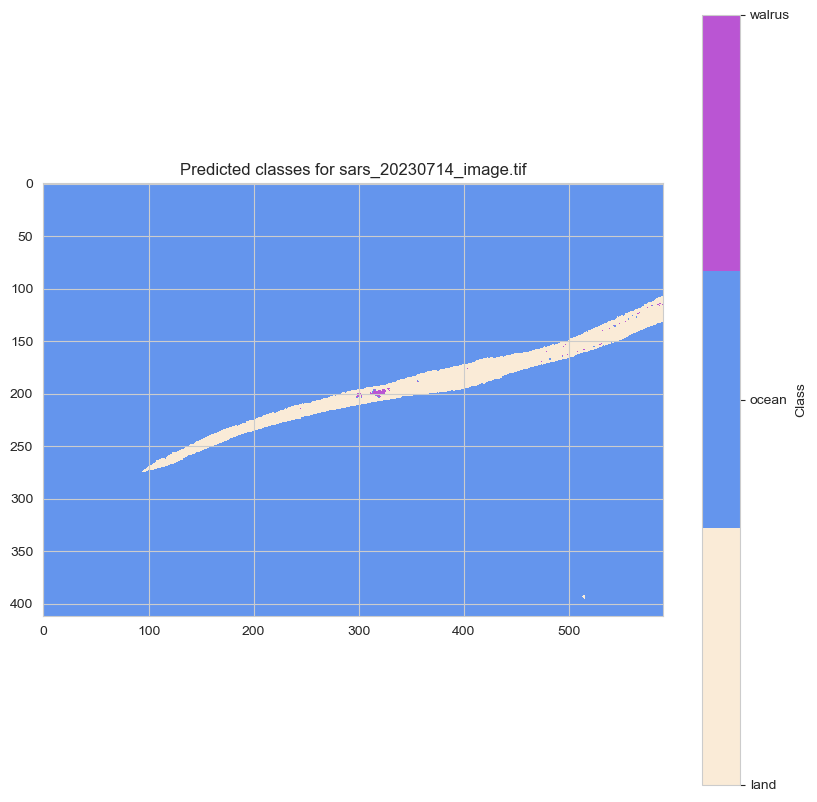

Inside post_process_prediction function.
Initial prediction shape: (155880,)
Initial is_1d: True
Reshaped prediction to: (360, 433)
Pass 1/3
Ocean mask sum: 150937
Ocean mask 2D shape: (360, 433)
Structure shape: (30, 30)
Ocean buffer created. Shape: (360, 433)
Walrus mask updated. Walrus count: 61
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 150928
Pass 2/3
Ocean mask sum: 150928
Ocean mask 2D shape: (360, 433)
Structure shape: (30, 30)
Ocean buffer created. Shape: (360, 433)
Walrus mask updated. Walrus count: 61
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 150928
Pass 3/3
Ocean mask sum: 150928
Ocean mask 2D shape: (360, 433)
Structure shape: (30, 30)
Ocean buffer created. Shape: (360, 433)
Walrus mask updated. Walrus count: 61
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 150928
Final prediction shape: (360, 433)


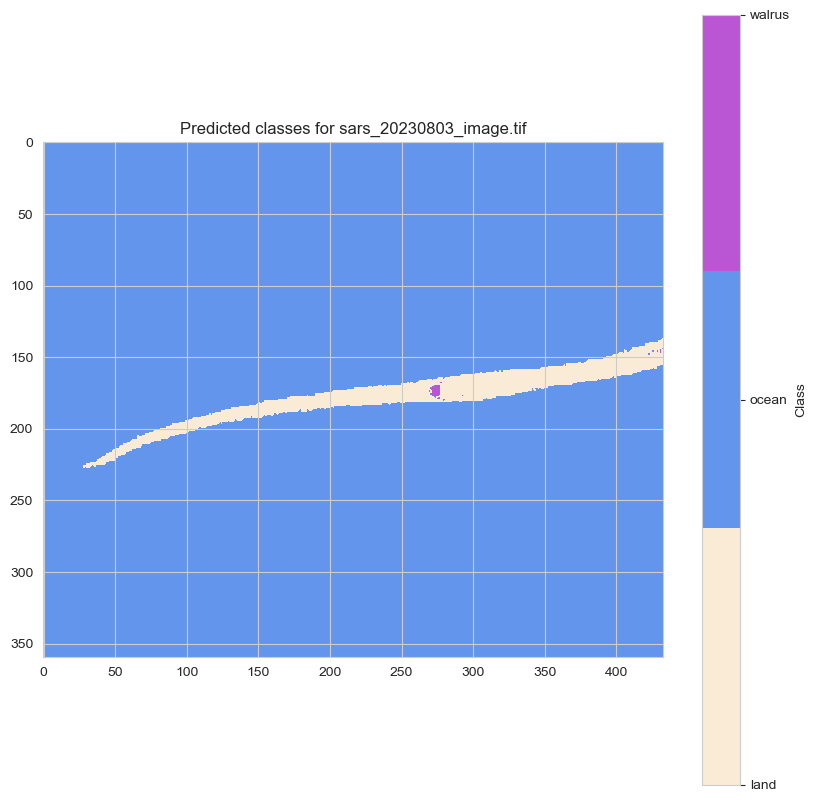

Inside post_process_prediction function.
Initial prediction shape: (208395,)
Initial is_1d: True
Reshaped prediction to: (421, 495)
Pass 1/3
Ocean mask sum: 127518
Ocean mask 2D shape: (421, 495)
Structure shape: (30, 30)
Ocean buffer created. Shape: (421, 495)
Walrus mask updated. Walrus count: 52
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 127503
Pass 2/3
Ocean mask sum: 127503
Ocean mask 2D shape: (421, 495)
Structure shape: (30, 30)
Ocean buffer created. Shape: (421, 495)
Walrus mask updated. Walrus count: 52
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 127503
Pass 3/3
Ocean mask sum: 127503
Ocean mask 2D shape: (421, 495)
Structure shape: (30, 30)
Ocean buffer created. Shape: (421, 495)
Walrus mask updated. Walrus count: 52
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 127503
Final prediction shape: (421, 495)


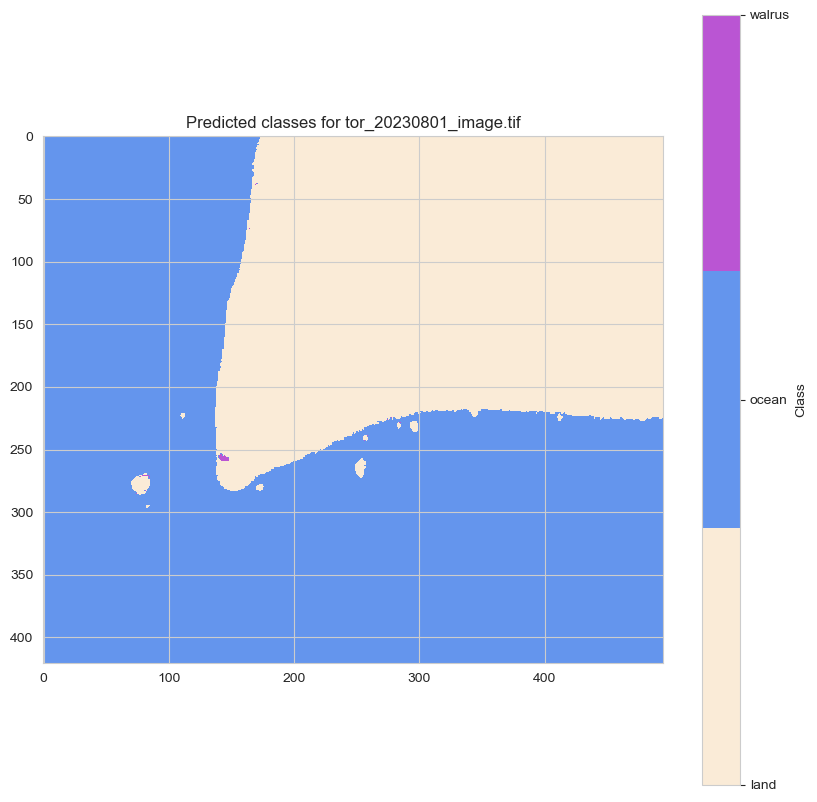

Inside post_process_prediction function.
Initial prediction shape: (136710,)
Initial is_1d: True
Reshaped prediction to: (310, 441)
Pass 1/3
Ocean mask sum: 85303
Ocean mask 2D shape: (310, 441)
Structure shape: (30, 30)
Ocean buffer created. Shape: (310, 441)
Walrus mask updated. Walrus count: 267
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 85300
Pass 2/3
Ocean mask sum: 85300
Ocean mask 2D shape: (310, 441)
Structure shape: (30, 30)
Ocean buffer created. Shape: (310, 441)
Walrus mask updated. Walrus count: 267
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 85300
Pass 3/3
Ocean mask sum: 85300
Ocean mask 2D shape: (310, 441)
Structure shape: (30, 30)
Ocean buffer created. Shape: (310, 441)
Walrus mask updated. Walrus count: 267
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 85300
Final prediction shape: (310, 441)


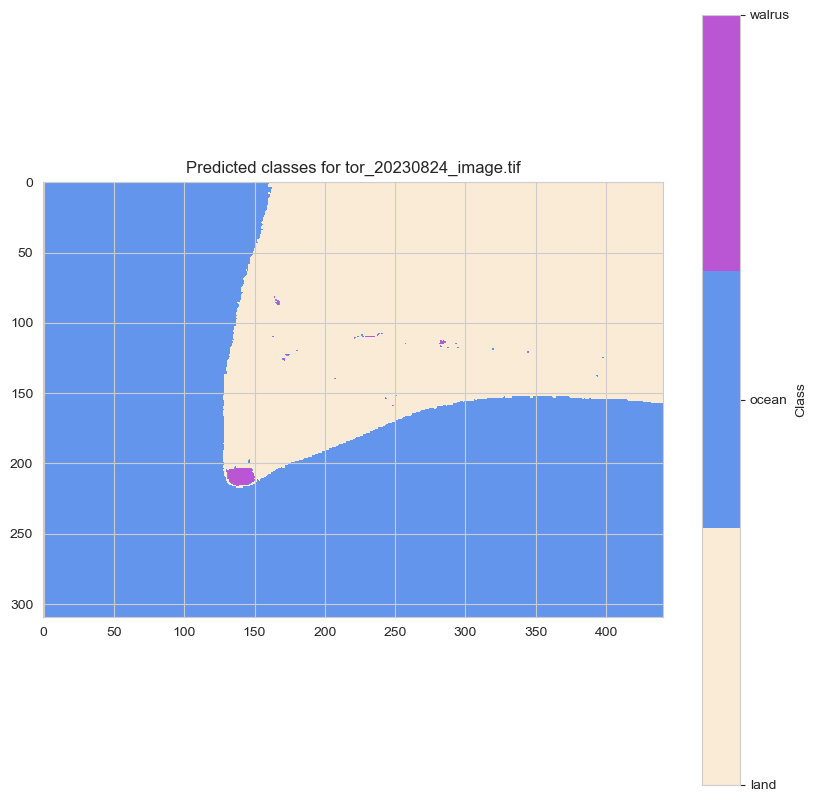

Inside post_process_prediction function.
Initial prediction shape: (207060,)
Initial is_1d: True
Reshaped prediction to: (420, 493)
Pass 1/3
Ocean mask sum: 122610
Ocean mask 2D shape: (420, 493)
Structure shape: (30, 30)
Ocean buffer created. Shape: (420, 493)
Walrus mask updated. Walrus count: 65
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 122603
Pass 2/3
Ocean mask sum: 122603
Ocean mask 2D shape: (420, 493)
Structure shape: (30, 30)
Ocean buffer created. Shape: (420, 493)
Walrus mask updated. Walrus count: 65
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 122603
Pass 3/3
Ocean mask sum: 122603
Ocean mask 2D shape: (420, 493)
Structure shape: (30, 30)
Ocean buffer created. Shape: (420, 493)
Walrus mask updated. Walrus count: 65
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 122603
Final prediction shape: (420, 493)


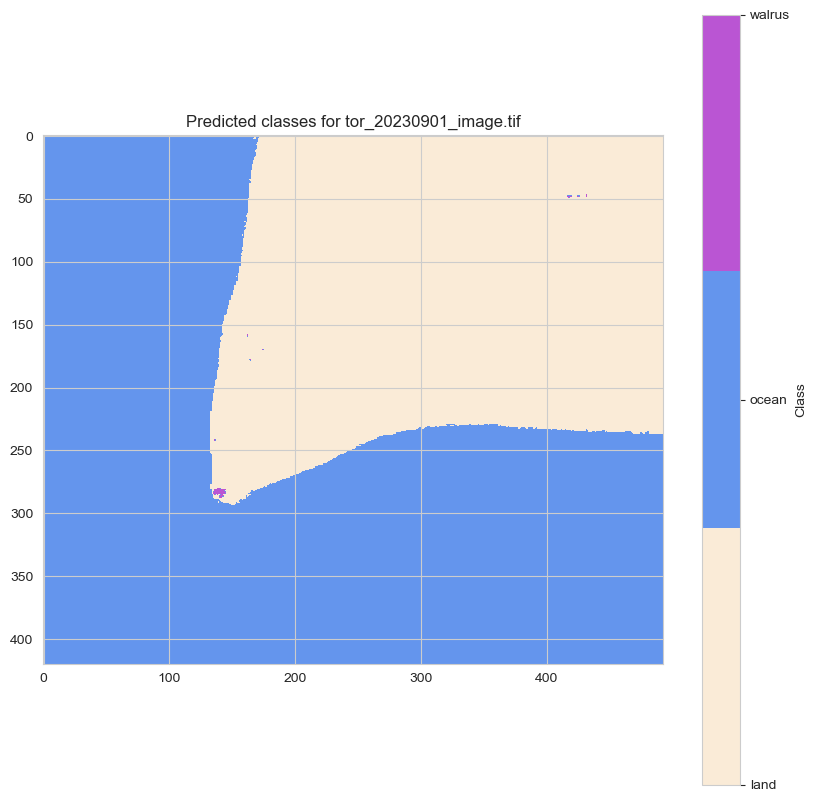

Inside post_process_prediction function.
Initial prediction shape: (207060,)
Initial is_1d: True
Reshaped prediction to: (420, 493)
Pass 1/3
Ocean mask sum: 115507
Ocean mask 2D shape: (420, 493)
Structure shape: (30, 30)
Ocean buffer created. Shape: (420, 493)
Walrus mask updated. Walrus count: 183
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 115472
Pass 2/3
Ocean mask sum: 115472
Ocean mask 2D shape: (420, 493)
Structure shape: (30, 30)
Ocean buffer created. Shape: (420, 493)
Walrus mask updated. Walrus count: 183
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 115472
Pass 3/3
Ocean mask sum: 115472
Ocean mask 2D shape: (420, 493)
Structure shape: (30, 30)
Ocean buffer created. Shape: (420, 493)
Walrus mask updated. Walrus count: 183
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 115472
Final prediction shape: (420, 493)

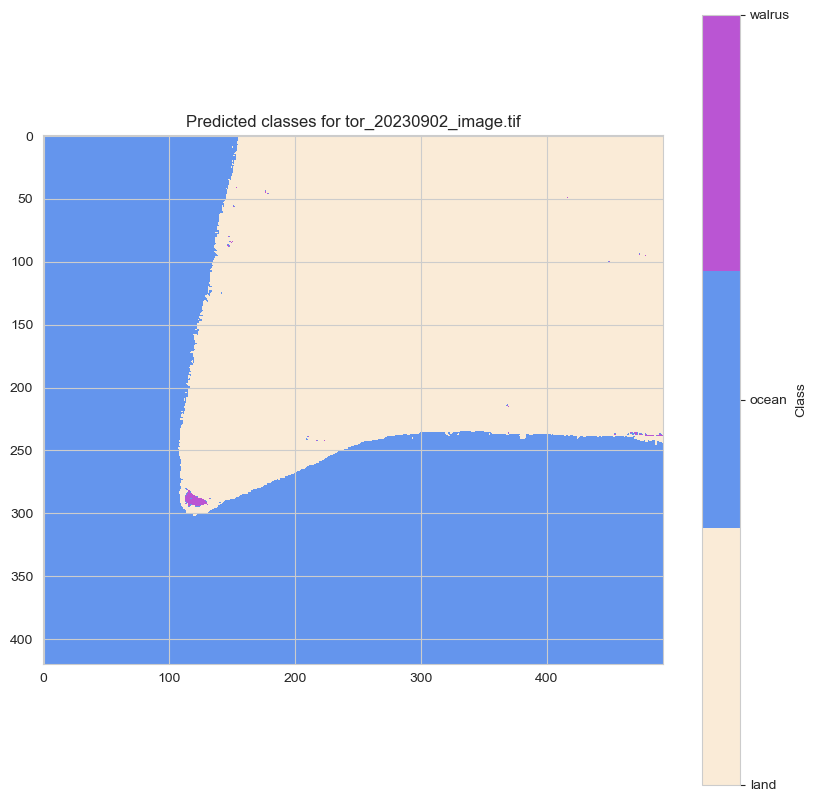

Inside post_process_prediction function.
Initial prediction shape: (52740,)
Initial is_1d: True
Reshaped prediction to: (180, 293)
Pass 1/3
Ocean mask sum: 24400
Ocean mask 2D shape: (180, 293)
Structure shape: (30, 30)
Ocean buffer created. Shape: (180, 293)
Walrus mask updated. Walrus count: 1227
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 24097
Pass 2/3
Ocean mask sum: 24097
Ocean mask 2D shape: (180, 293)
Structure shape: (30, 30)
Ocean buffer created. Shape: (180, 293)
Walrus mask updated. Walrus count: 1203
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 24097
Pass 3/3
Ocean mask sum: 24097
Ocean mask 2D shape: (180, 293)
Structure shape: (30, 30)
Ocean buffer created. Shape: (180, 293)
Walrus mask updated. Walrus count: 1203
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 24097
Final prediction shape: (180, 293)


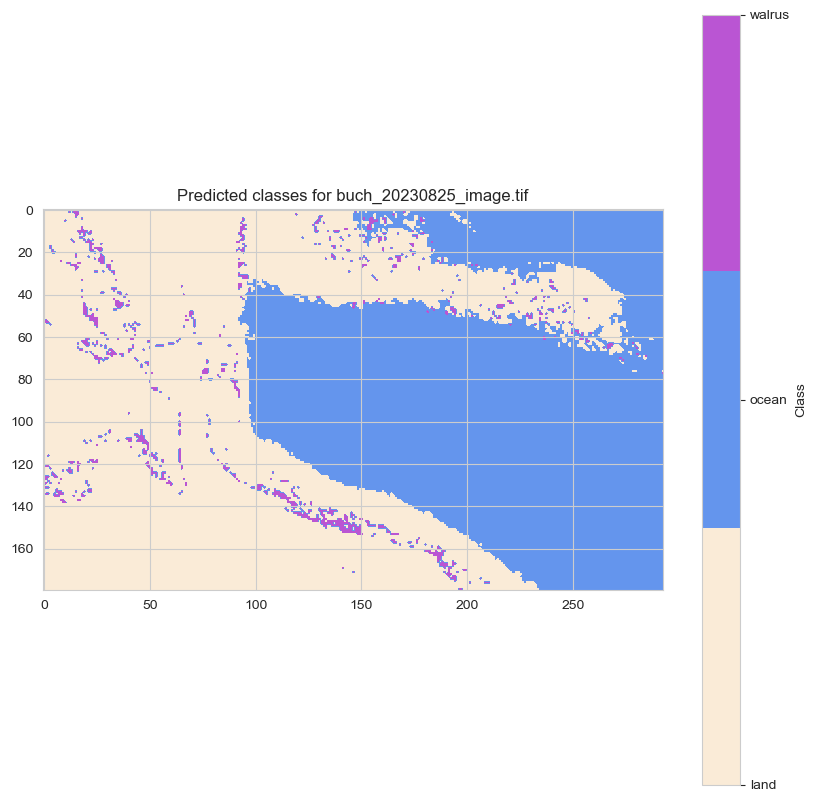

Inside post_process_prediction function.
Initial prediction shape: (51300,)
Initial is_1d: True
Reshaped prediction to: (180, 285)
Pass 1/3
Ocean mask sum: 24813
Ocean mask 2D shape: (180, 285)
Structure shape: (30, 30)
Ocean buffer created. Shape: (180, 285)
Walrus mask updated. Walrus count: 750
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 24671
Pass 2/3
Ocean mask sum: 24671
Ocean mask 2D shape: (180, 285)
Structure shape: (30, 30)
Ocean buffer created. Shape: (180, 285)
Walrus mask updated. Walrus count: 733
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 24671
Pass 3/3
Ocean mask sum: 24671
Ocean mask 2D shape: (180, 285)
Structure shape: (30, 30)
Ocean buffer created. Shape: (180, 285)
Walrus mask updated. Walrus count: 733
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 24671
Final prediction shape: (180, 285)


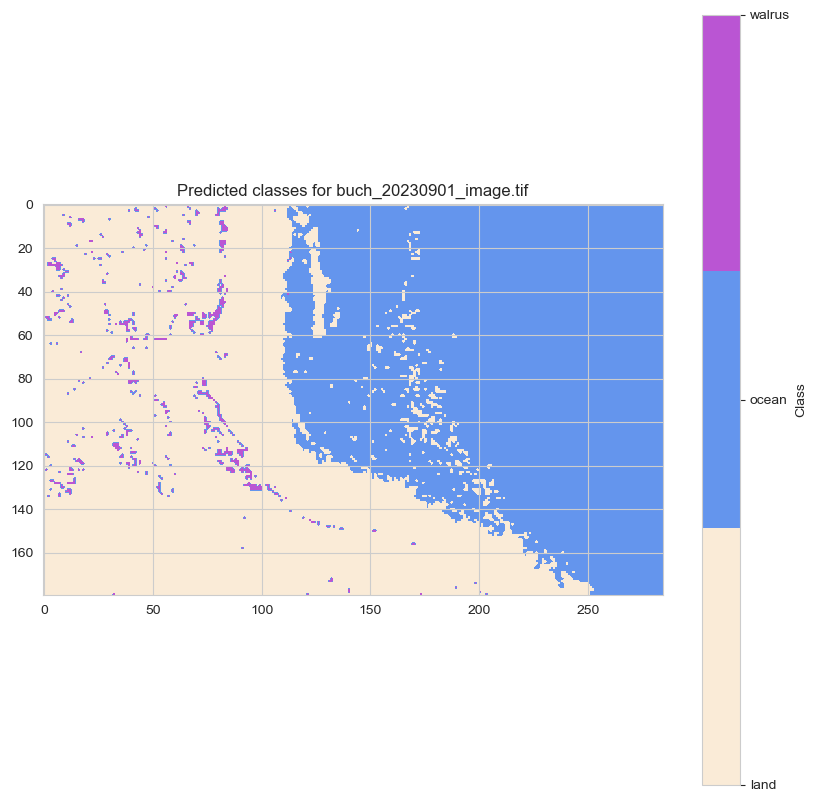

Inside post_process_prediction function.
Initial prediction shape: (141550,)
Initial is_1d: True
Reshaped prediction to: (298, 475)
Pass 1/3
Ocean mask sum: 104586
Ocean mask 2D shape: (298, 475)
Structure shape: (30, 30)
Ocean buffer created. Shape: (298, 475)
Walrus mask updated. Walrus count: 544
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 104434
Pass 2/3
Ocean mask sum: 104434
Ocean mask 2D shape: (298, 475)
Structure shape: (30, 30)
Ocean buffer created. Shape: (298, 475)
Walrus mask updated. Walrus count: 544
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 104434
Pass 3/3
Ocean mask sum: 104434
Ocean mask 2D shape: (298, 475)
Structure shape: (30, 30)
Ocean buffer created. Shape: (298, 475)
Walrus mask updated. Walrus count: 544
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 104434
Final prediction shape: (298, 475)

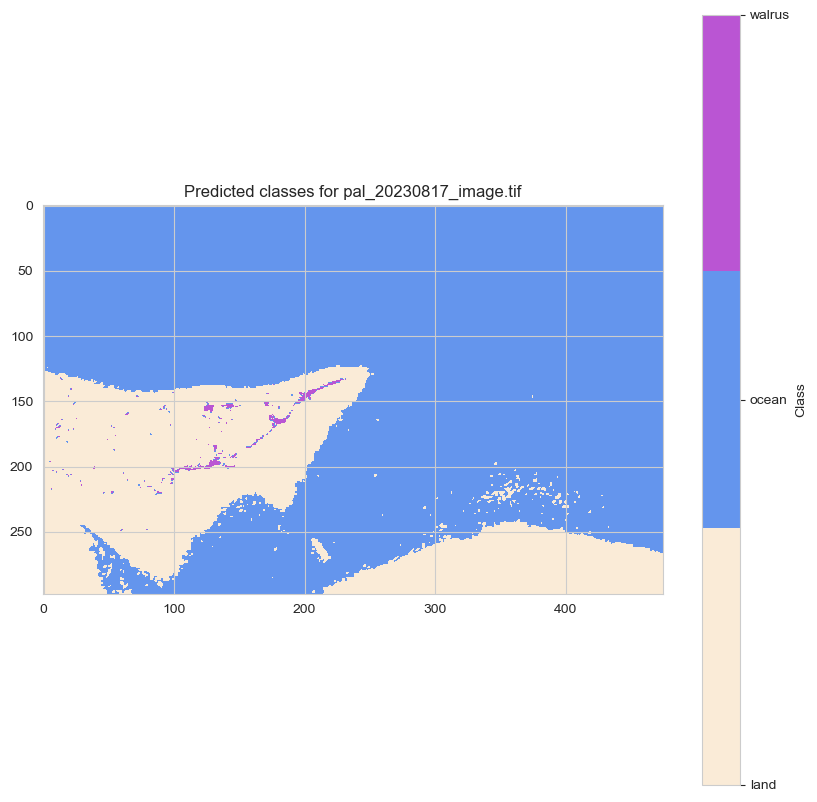

Inside post_process_prediction function.
Initial prediction shape: (249845,)
Initial is_1d: True
Reshaped prediction to: (467, 535)
Pass 1/3
Ocean mask sum: 152952
Ocean mask 2D shape: (467, 535)
Structure shape: (30, 30)
Ocean buffer created. Shape: (467, 535)
Walrus mask updated. Walrus count: 337
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 141542
Pass 2/3
Ocean mask sum: 141542
Ocean mask 2D shape: (467, 535)
Structure shape: (30, 30)
Ocean buffer created. Shape: (467, 535)
Walrus mask updated. Walrus count: 304
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 141542
Pass 3/3
Ocean mask sum: 141542
Ocean mask 2D shape: (467, 535)
Structure shape: (30, 30)
Ocean buffer created. Shape: (467, 535)
Walrus mask updated. Walrus count: 304
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 141542
Final prediction shape: (467, 535)

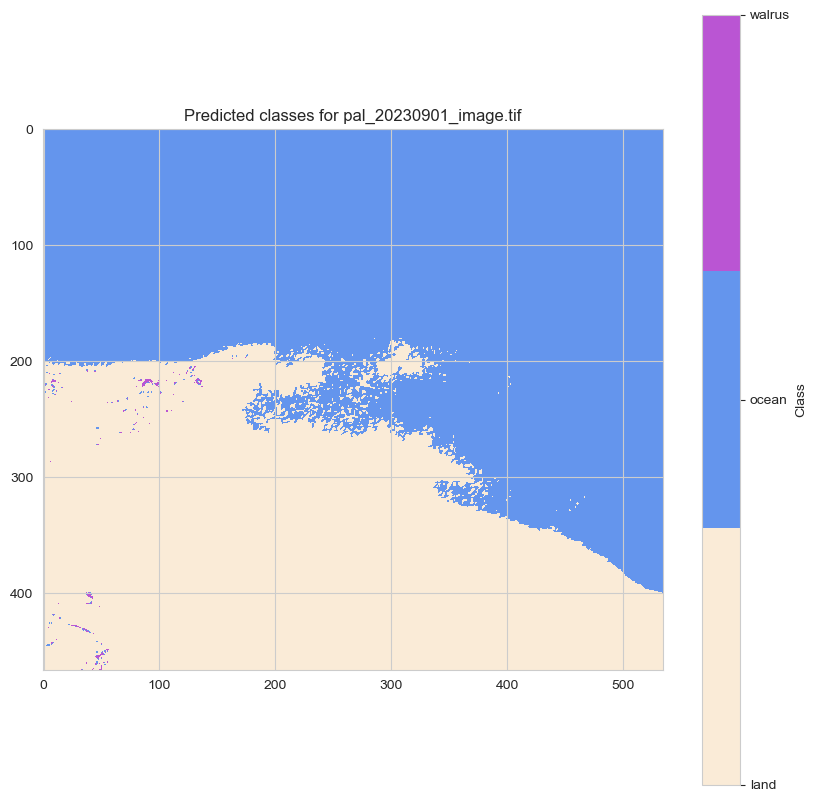

Inside post_process_prediction function.
Initial prediction shape: (142025,)
Initial is_1d: True
Reshaped prediction to: (299, 475)
Pass 1/3
Ocean mask sum: 91337
Ocean mask 2D shape: (299, 475)
Structure shape: (30, 30)
Ocean buffer created. Shape: (299, 475)
Walrus mask updated. Walrus count: 697
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 82791
Pass 2/3
Ocean mask sum: 82791
Ocean mask 2D shape: (299, 475)
Structure shape: (30, 30)
Ocean buffer created. Shape: (299, 475)
Walrus mask updated. Walrus count: 697
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 82791
Pass 3/3
Ocean mask sum: 82791
Ocean mask 2D shape: (299, 475)
Structure shape: (30, 30)
Ocean buffer created. Shape: (299, 475)
Walrus mask updated. Walrus count: 697
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 82791
Final prediction shape: (299, 475)


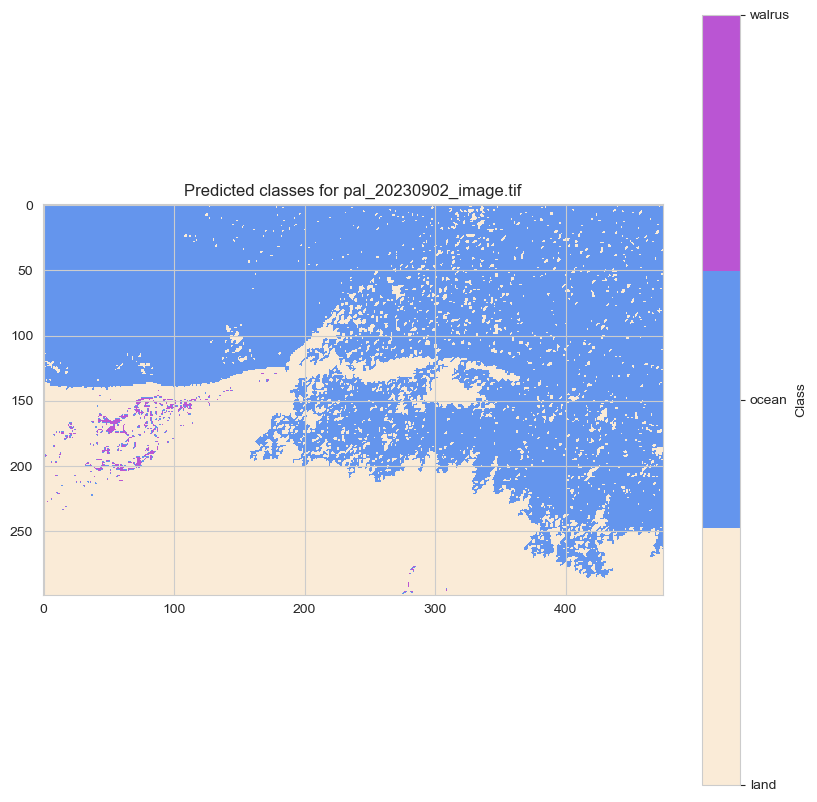

Inside post_process_prediction function.
Initial prediction shape: (249378,)
Initial is_1d: True
Reshaped prediction to: (467, 534)
Pass 1/3
Ocean mask sum: 136700
Ocean mask 2D shape: (467, 534)
Structure shape: (30, 30)
Ocean buffer created. Shape: (467, 534)
Walrus mask updated. Walrus count: 2780
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 131362
Pass 2/3
Ocean mask sum: 131362
Ocean mask 2D shape: (467, 534)
Structure shape: (30, 30)
Ocean buffer created. Shape: (467, 534)
Walrus mask updated. Walrus count: 2780
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 131362
Pass 3/3
Ocean mask sum: 131362
Ocean mask 2D shape: (467, 534)
Structure shape: (30, 30)
Ocean buffer created. Shape: (467, 534)
Walrus mask updated. Walrus count: 2780
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 131362
Final prediction shape: (467, 5

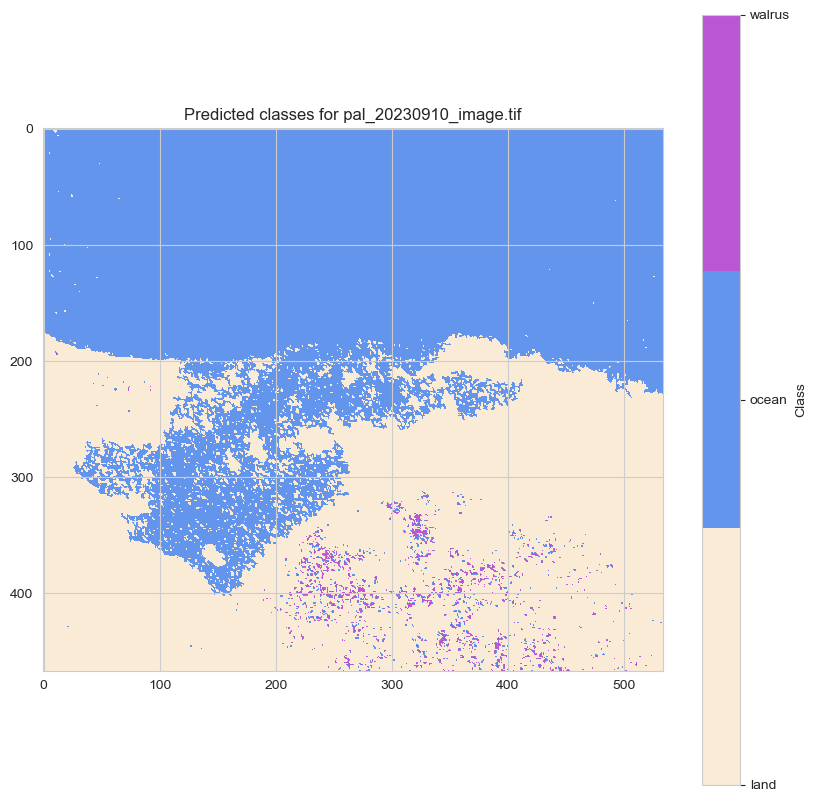

Inside post_process_prediction function.
Initial prediction shape: (1599716,)
Initial is_1d: True
Reshaped prediction to: (878, 1822)
Pass 1/3
Ocean mask sum: 30905
Ocean mask 2D shape: (878, 1822)
Structure shape: (30, 30)
Ocean buffer created. Shape: (878, 1822)
Walrus mask updated. Walrus count: 0
Speckles removed. Unique values: [0 1]
Removed smaller ocean regions. Ocean mask sum after removal: 13928
Pass 2/3
Ocean mask sum: 13928
Ocean mask 2D shape: (878, 1822)
Structure shape: (30, 30)
Ocean buffer created. Shape: (878, 1822)
Walrus mask updated. Walrus count: 0
Speckles removed. Unique values: [0 1]
Removed smaller ocean regions. Ocean mask sum after removal: 13928
Pass 3/3
Ocean mask sum: 13928
Ocean mask 2D shape: (878, 1822)
Structure shape: (30, 30)
Ocean buffer created. Shape: (878, 1822)
Walrus mask updated. Walrus count: 0
Speckles removed. Unique values: [0 1]
Removed smaller ocean regions. Ocean mask sum after removal: 13928
Final prediction shape: (878, 1822)


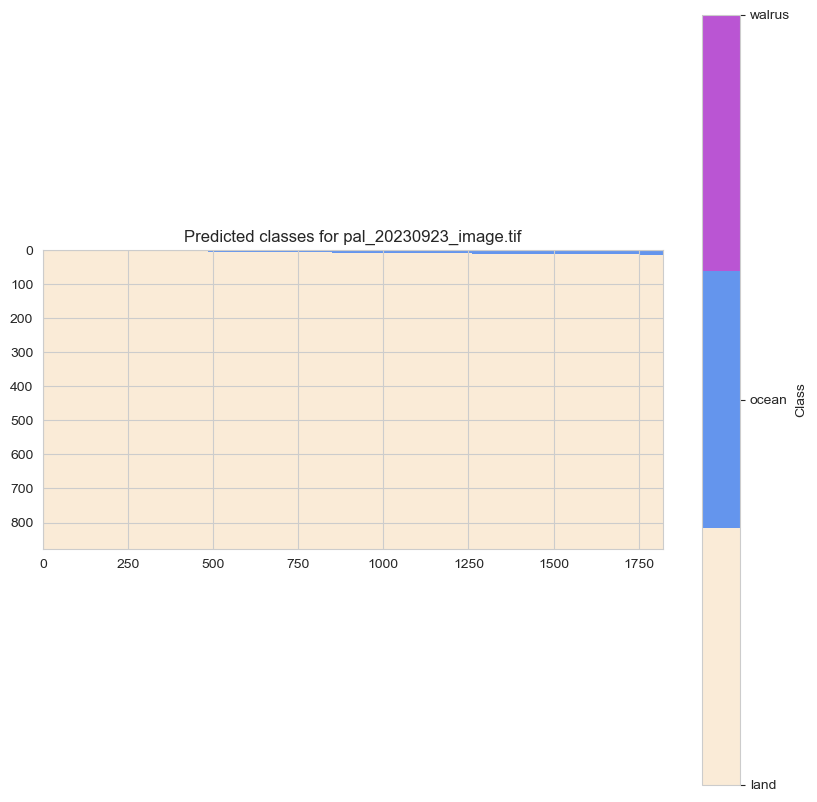

Inside post_process_prediction function.
Initial prediction shape: (278168,)
Initial is_1d: True
Reshaped prediction to: (436, 638)
Pass 1/3
Ocean mask sum: 266878
Ocean mask 2D shape: (436, 638)
Structure shape: (30, 30)
Ocean buffer created. Shape: (436, 638)
Walrus mask updated. Walrus count: 353
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 266824
Pass 2/3
Ocean mask sum: 266824
Ocean mask 2D shape: (436, 638)
Structure shape: (30, 30)
Ocean buffer created. Shape: (436, 638)
Walrus mask updated. Walrus count: 349
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 266824
Pass 3/3
Ocean mask sum: 266824
Ocean mask 2D shape: (436, 638)
Structure shape: (30, 30)
Ocean buffer created. Shape: (436, 638)
Walrus mask updated. Walrus count: 349
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 266824
Final prediction shape: (436, 638)

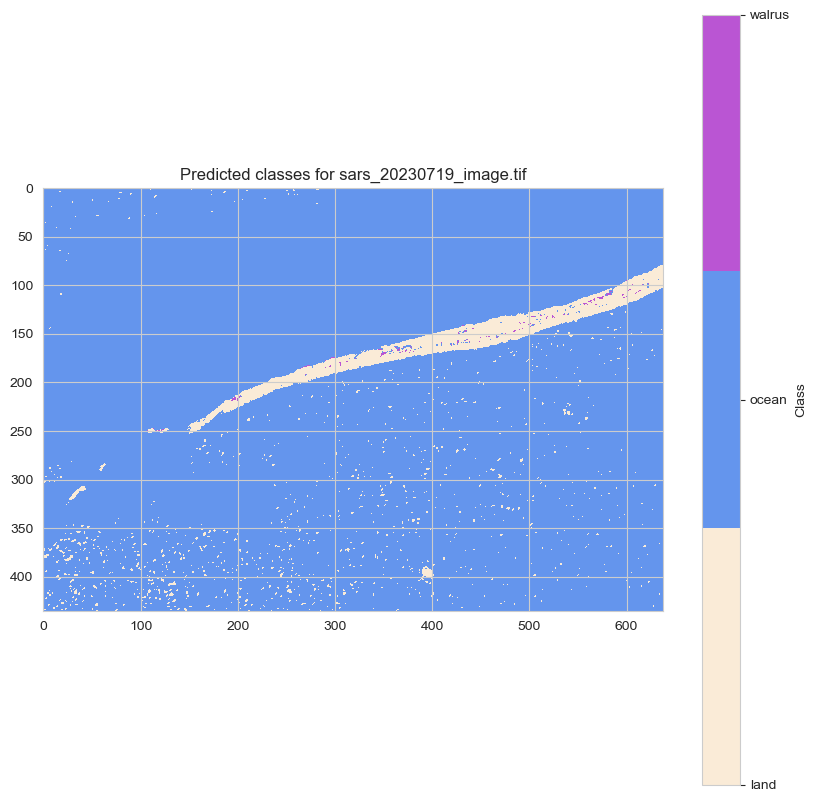

Inside post_process_prediction function.
Initial prediction shape: (119412,)
Initial is_1d: True
Reshaped prediction to: (279, 428)
Pass 1/3
Ocean mask sum: 109519
Ocean mask 2D shape: (279, 428)
Structure shape: (30, 30)
Ocean buffer created. Shape: (279, 428)
Walrus mask updated. Walrus count: 631
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 109169
Pass 2/3
Ocean mask sum: 109169
Ocean mask 2D shape: (279, 428)
Structure shape: (30, 30)
Ocean buffer created. Shape: (279, 428)
Walrus mask updated. Walrus count: 513
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 109169
Pass 3/3
Ocean mask sum: 109169
Ocean mask 2D shape: (279, 428)
Structure shape: (30, 30)
Ocean buffer created. Shape: (279, 428)
Walrus mask updated. Walrus count: 513
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 109169
Final prediction shape: (279, 428)

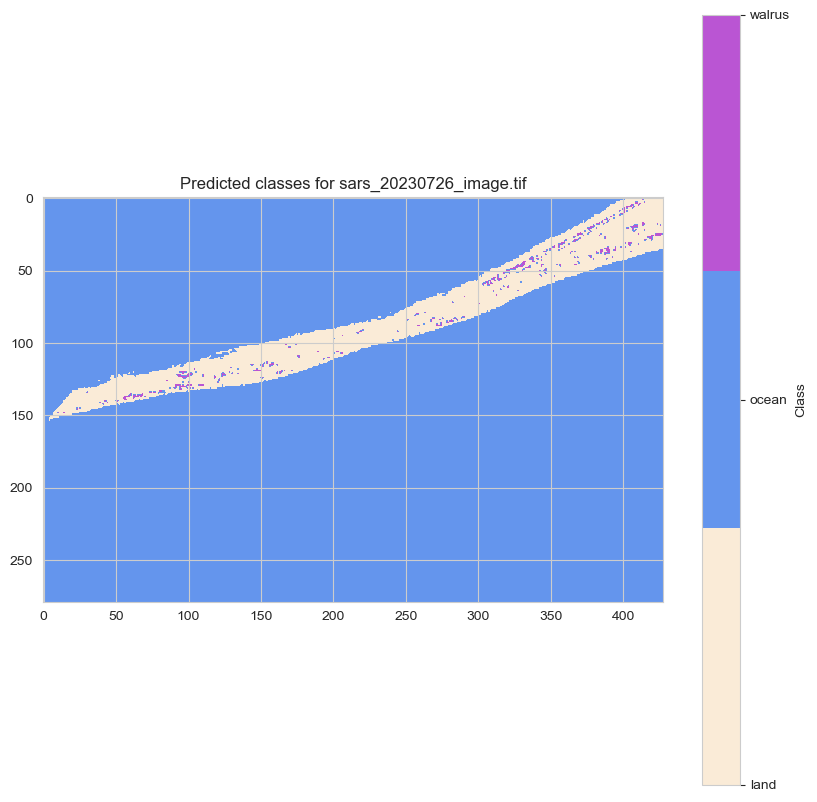

Inside post_process_prediction function.
Initial prediction shape: (162690,)
Initial is_1d: True
Reshaped prediction to: (319, 510)
Pass 1/3
Ocean mask sum: 155766
Ocean mask 2D shape: (319, 510)
Structure shape: (30, 30)
Ocean buffer created. Shape: (319, 510)
Walrus mask updated. Walrus count: 273
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 155762
Pass 2/3
Ocean mask sum: 155762
Ocean mask 2D shape: (319, 510)
Structure shape: (30, 30)
Ocean buffer created. Shape: (319, 510)
Walrus mask updated. Walrus count: 273
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 155762
Pass 3/3
Ocean mask sum: 155762
Ocean mask 2D shape: (319, 510)
Structure shape: (30, 30)
Ocean buffer created. Shape: (319, 510)
Walrus mask updated. Walrus count: 273
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 155762
Final prediction shape: (319, 510)

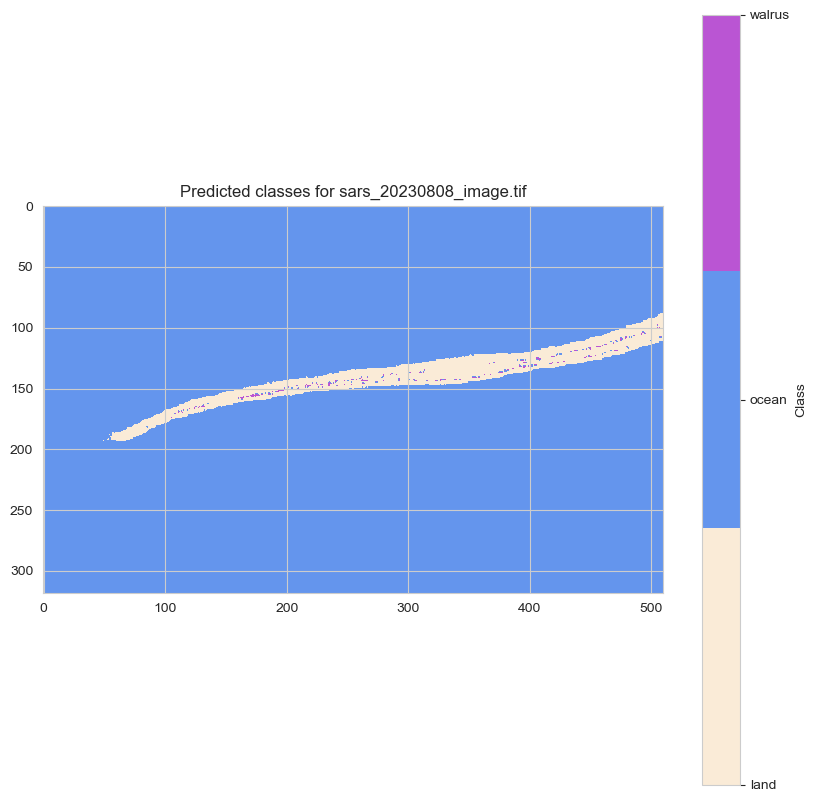

Inside post_process_prediction function.
Initial prediction shape: (32256,)
Initial is_1d: True
Reshaped prediction to: (144, 224)
Pass 1/3
Ocean mask sum: 16480
Ocean mask 2D shape: (144, 224)
Structure shape: (30, 30)
Ocean buffer created. Shape: (144, 224)
Walrus mask updated. Walrus count: 180
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 15586
Pass 2/3
Ocean mask sum: 15586
Ocean mask 2D shape: (144, 224)
Structure shape: (30, 30)
Ocean buffer created. Shape: (144, 224)
Walrus mask updated. Walrus count: 179
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 15586
Pass 3/3
Ocean mask sum: 15586
Ocean mask 2D shape: (144, 224)
Structure shape: (30, 30)
Ocean buffer created. Shape: (144, 224)
Walrus mask updated. Walrus count: 179
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 15586
Final prediction shape: (144, 224)


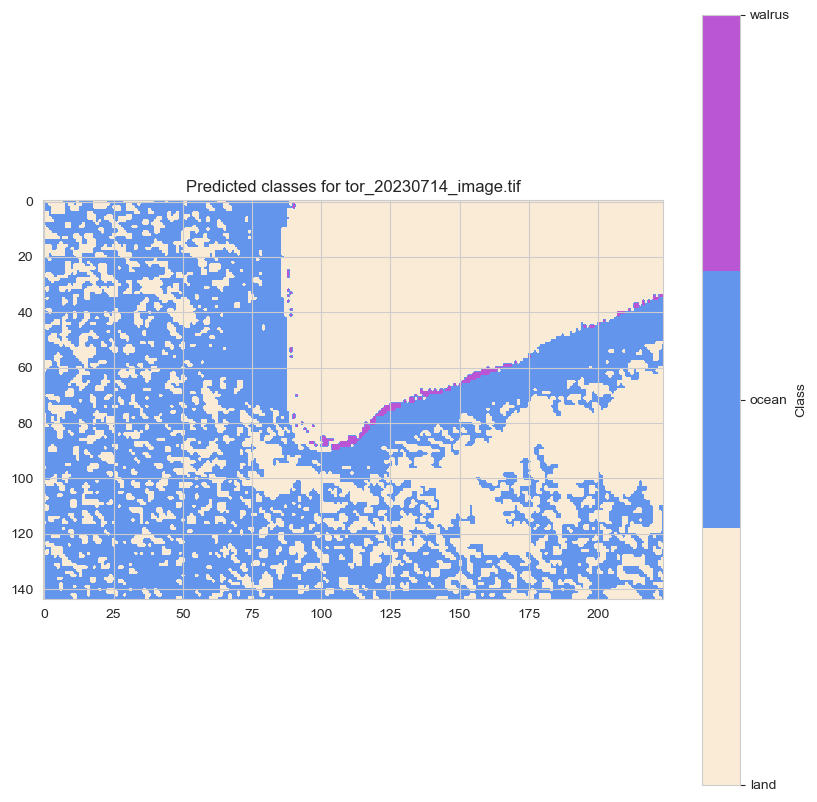

Inside post_process_prediction function.
Initial prediction shape: (33120,)
Initial is_1d: True
Reshaped prediction to: (144, 230)
Pass 1/3
Ocean mask sum: 23307
Ocean mask 2D shape: (144, 230)
Structure shape: (30, 30)
Ocean buffer created. Shape: (144, 230)
Walrus mask updated. Walrus count: 19
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 23274
Pass 2/3
Ocean mask sum: 23274
Ocean mask 2D shape: (144, 230)
Structure shape: (30, 30)
Ocean buffer created. Shape: (144, 230)
Walrus mask updated. Walrus count: 19
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 23274
Pass 3/3
Ocean mask sum: 23274
Ocean mask 2D shape: (144, 230)
Structure shape: (30, 30)
Ocean buffer created. Shape: (144, 230)
Walrus mask updated. Walrus count: 19
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 23274
Final prediction shape: (144, 230)


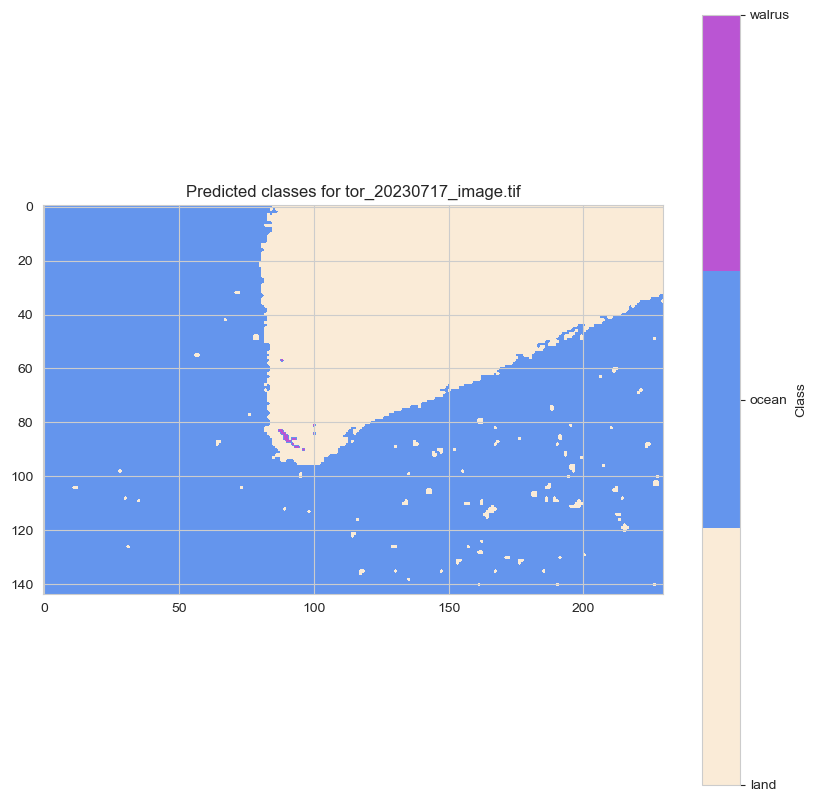

Inside post_process_prediction function.
Initial prediction shape: (21924,)
Initial is_1d: True
Reshaped prediction to: (116, 189)
Pass 1/3
Ocean mask sum: 15449
Ocean mask 2D shape: (116, 189)
Structure shape: (30, 30)
Ocean buffer created. Shape: (116, 189)
Walrus mask updated. Walrus count: 2
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 15449
Pass 2/3
Ocean mask sum: 15449
Ocean mask 2D shape: (116, 189)
Structure shape: (30, 30)
Ocean buffer created. Shape: (116, 189)
Walrus mask updated. Walrus count: 2
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 15449
Pass 3/3
Ocean mask sum: 15449
Ocean mask 2D shape: (116, 189)
Structure shape: (30, 30)
Ocean buffer created. Shape: (116, 189)
Walrus mask updated. Walrus count: 2
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 15449
Final prediction shape: (116, 189)


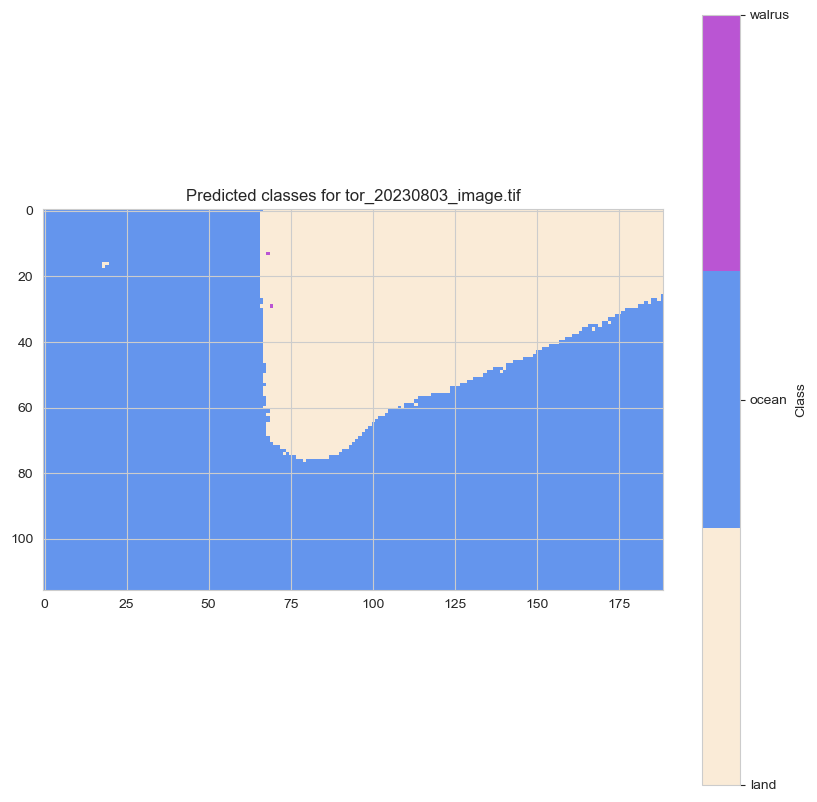

Inside post_process_prediction function.
Initial prediction shape: (52740,)
Initial is_1d: True
Reshaped prediction to: (180, 293)
Pass 1/3
Ocean mask sum: 37886
Ocean mask 2D shape: (180, 293)
Structure shape: (30, 30)
Ocean buffer created. Shape: (180, 293)
Walrus mask updated. Walrus count: 74
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 37870
Pass 2/3
Ocean mask sum: 37870
Ocean mask 2D shape: (180, 293)
Structure shape: (30, 30)
Ocean buffer created. Shape: (180, 293)
Walrus mask updated. Walrus count: 74
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 37870
Pass 3/3
Ocean mask sum: 37870
Ocean mask 2D shape: (180, 293)
Structure shape: (30, 30)
Ocean buffer created. Shape: (180, 293)
Walrus mask updated. Walrus count: 74
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 37870
Final prediction shape: (180, 293)


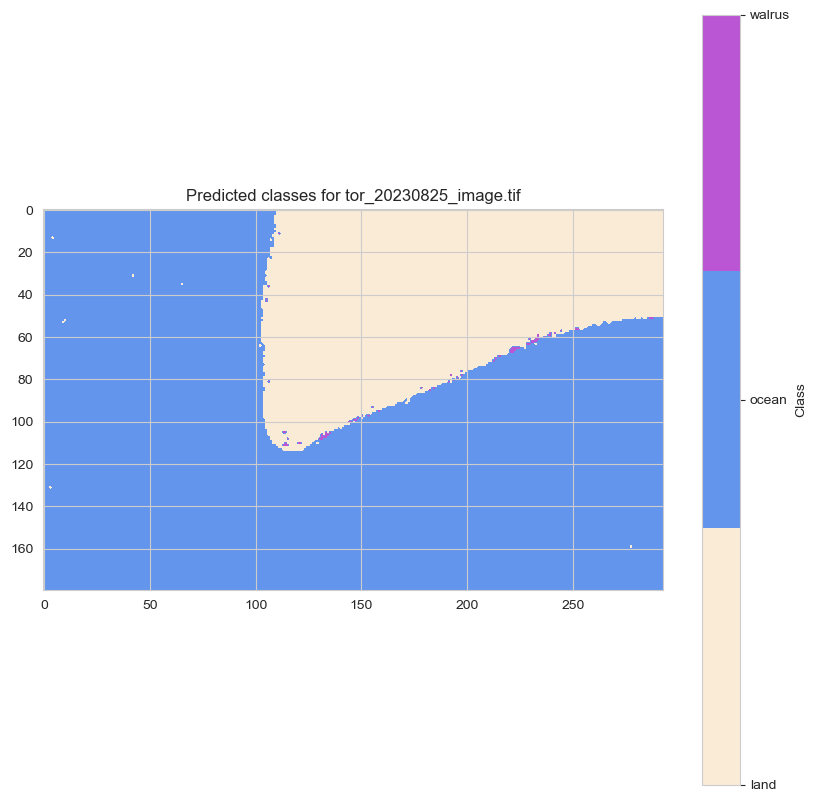

Inside post_process_prediction function.
Initial prediction shape: (51480,)
Initial is_1d: True
Reshaped prediction to: (180, 286)
Pass 1/3
Ocean mask sum: 27581
Ocean mask 2D shape: (180, 286)
Structure shape: (30, 30)
Ocean buffer created. Shape: (180, 286)
Walrus mask updated. Walrus count: 347
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 25922
Pass 2/3
Ocean mask sum: 25922
Ocean mask 2D shape: (180, 286)
Structure shape: (30, 30)
Ocean buffer created. Shape: (180, 286)
Walrus mask updated. Walrus count: 341
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 25922
Pass 3/3
Ocean mask sum: 25922
Ocean mask 2D shape: (180, 286)
Structure shape: (30, 30)
Ocean buffer created. Shape: (180, 286)
Walrus mask updated. Walrus count: 341
Speckles removed. Unique values: [0 1 2]
Removed smaller ocean regions. Ocean mask sum after removal: 25922
Final prediction shape: (180, 286)


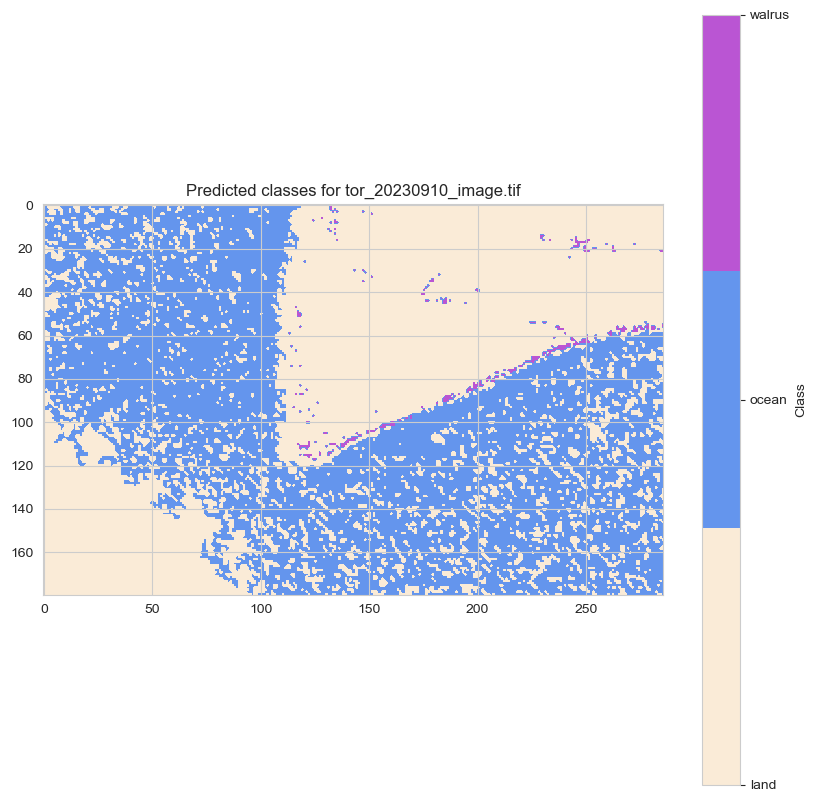

In [14]:
# Define a color map for the labels
label_colors = {
    'ocean': 'cornflowerblue',
    'land': 'antiquewhite',
    'walrus': 'mediumorchid'
}

# Create a fixed color map based on combined labels
cmap = mcolors.ListedColormap([label_colors[label] for label in combined_le.classes_])

# Function to plot predicted images using the centralized prediction function
def plot_predicted_image(image_path, binary_model, walrus_model):
    post_processed_predictions, original_shape = predict_and_post_process(image_path, binary_model, walrus_model)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(post_processed_predictions, cmap=cmap, vmin=0, vmax=len(combined_le.classes_)-1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels(combined_le.classes_)

    plt.show()

# Predict and plot images using the new centralized function
for image_path in image_paths + unlabeled_image_paths:
    plot_predicted_image(image_path, binary_model, walrus_model)
